## PSF photometry with uncertainties

This notebook runs through the process of PSF photometry but implements array-location dependent corrections and uncertainties in the apparent magnitudes. The next iteration after this code will attempt to clean it up to enable greater customisation for different files and epochs and combine it with aperture photometry by using functions which should complete the photometry aspect of this work, ready to complete light curves.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from astropy.io import fits # used for FITS file management
from astropy.stats import sigma_clipped_stats # used within star detection
from astropy.table import Table
from astropy.nddata import NDData
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from photutils import aperture_photometry # used to perform photometry using annuli
from photutils import DAOStarFinder # used for the star finding algorithm
from photutils import CircularAperture, CircularAnnulus
from photutils import EPSFBuilder
from photutils.psf import extract_stars
from photutils.psf import DAOGroup
from photutils.psf import BasicPSFPhotometry
from photutils.psf import IterativelySubtractedPSFPhotometry
from photutils.background import MMMBackground

PAL5_data/PAL5__e1/PAL5__e1_3p6um.fits
FLUXCONV = 0.1257
EXPTIME = 71.3724


34


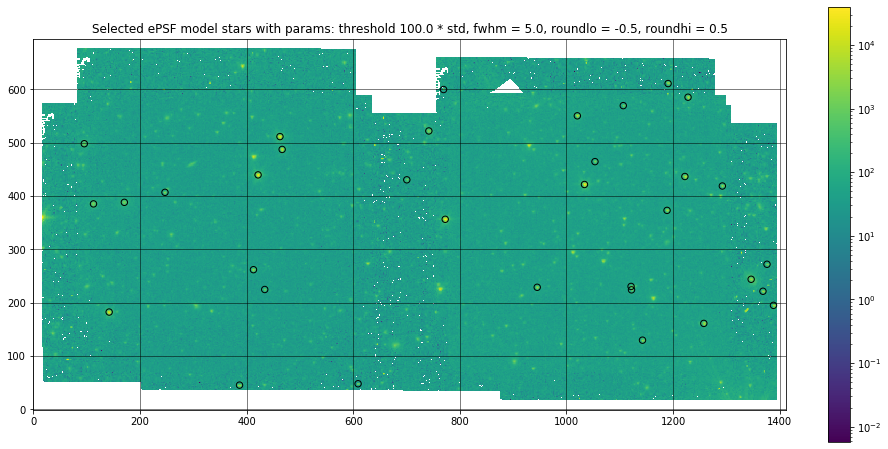

 id      xcenter       ...      aper_bkg      aper_sum_bkgsub  
           pix         ...                                     
--- ------------------ ... ----------------- ------------------
  1 386.74295292483225 ... 5529.953810103007 38796.442407212395
  2  609.1207788533914 ...  4242.52160498129 10810.107057863164
  3 1142.6191445428262 ... 6213.305147945754  33401.67795837177
  4 1257.6453165205398 ... 6496.728208037017  73457.07486642095
  5 142.19432814143948 ... 9266.086737461517  288163.1906789933
  6 1388.3105215450903 ... 6257.736613845463  75313.84508638266
  7 1368.5425066815278 ... 5741.214890570008  48055.40033309441
  8  1122.022315388808 ... 6034.968376498138  30137.95315646407
  9  434.0244199679025 ... 4845.249069773249 16992.874429461626
 10  945.1416618695562 ... 5890.363123522634  52933.44575304011
...                ... ...               ...                ...
 25 1053.4521137107763 ... 5413.399840615873 23261.493561006446
 26  466.7058234166519 ... 7303.32567433

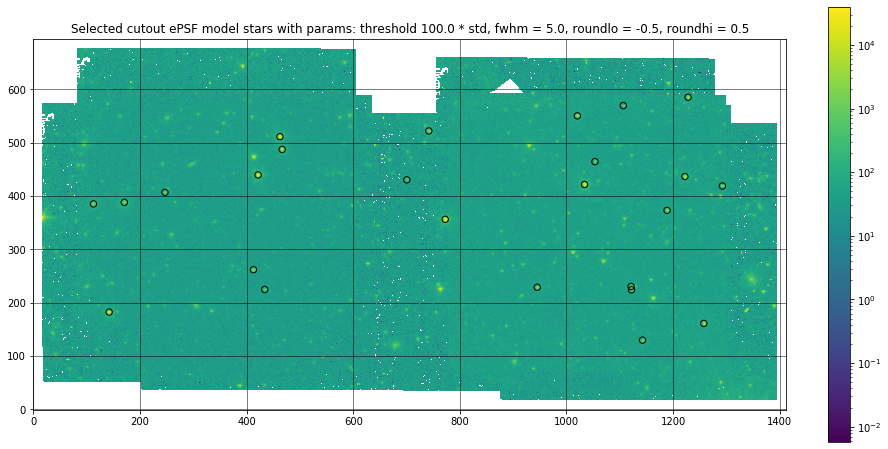

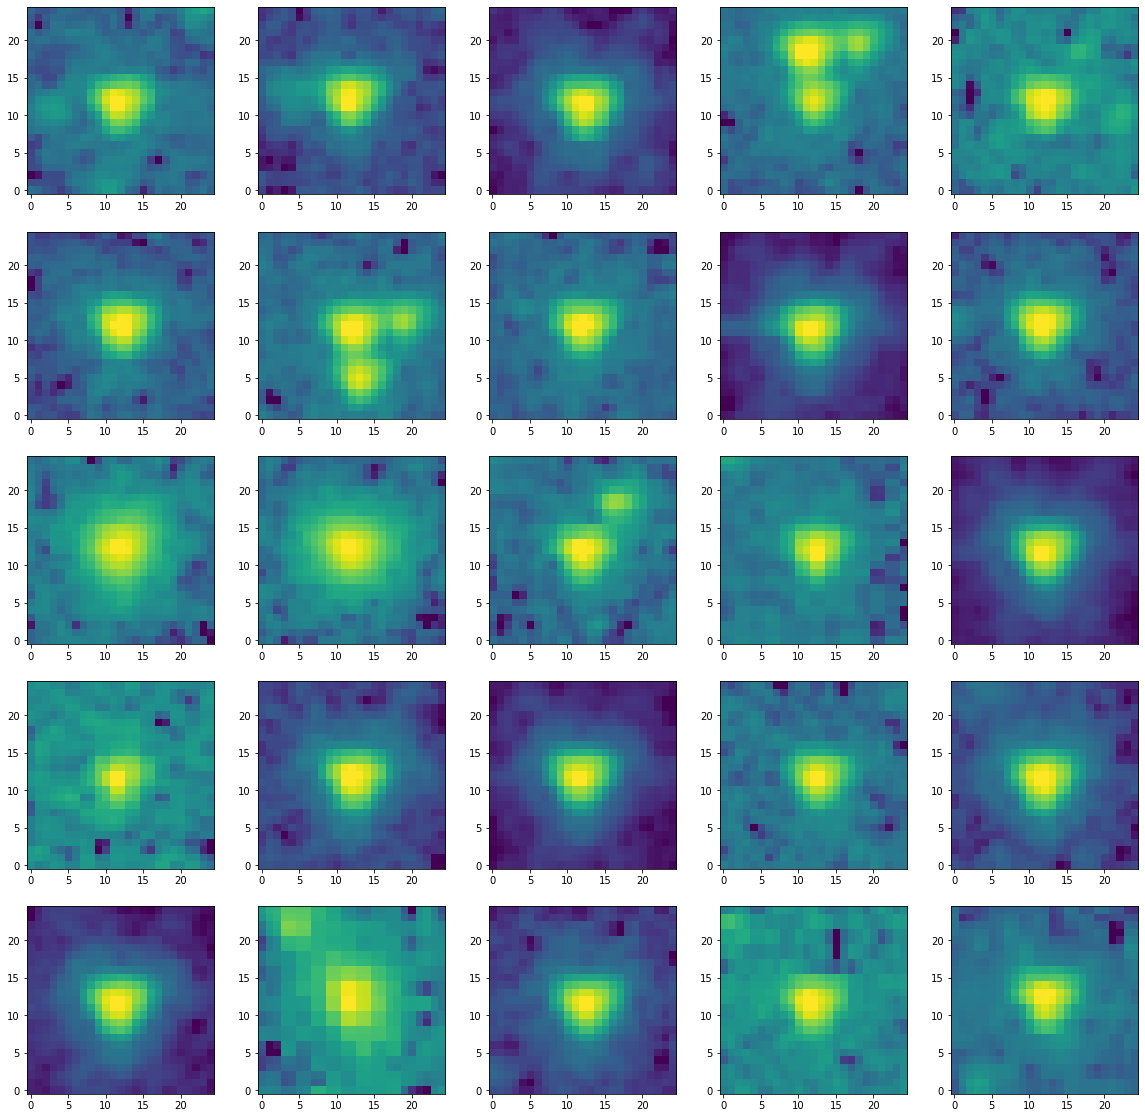

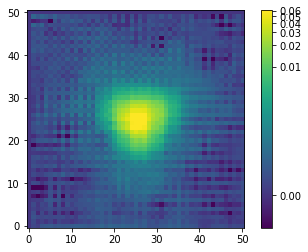

HERE
 id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  1 1182.2691587688644 ... 1.0382647758432952  -0.04077030098752918
  2  1335.720143020897 ... 1.3888911676615976   -0.3566705403055107
  3 1017.0720463346273 ... 1.2178547537433262  -0.21398873919614947
  4 1325.4233008232586 ...  39.52996485401895    -3.992316070532836
  5   1346.68596402586 ... 1.0238008183155174 -0.025538680855872343
  6 1267.5653109644136 ... 3.3984275835494526   -1.3281950501447808
  7 1138.3723108598422 ... 2.3597614394203945   -0.9321702502428958
  8 1300.2369547517922 ...  5.266005263213993   -1.8037032220863707
  9  886.2398603803223 ... 1.1286703094357793  -0.13141775183862406
 10 1323.7404837650017 ... 1.0019778213287396 -0.002145271439978394
...                ... ...                ...                   ...
729  980.1803416221136 ... 2.5553004027582156   -1.0186049085264068
730  766.3961557521801 ... 1.19945036623474

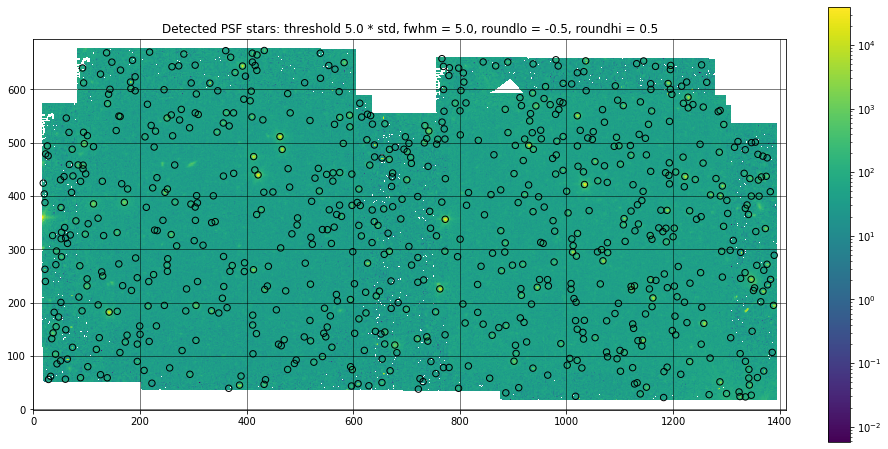

Number of stars detected = 739


1218


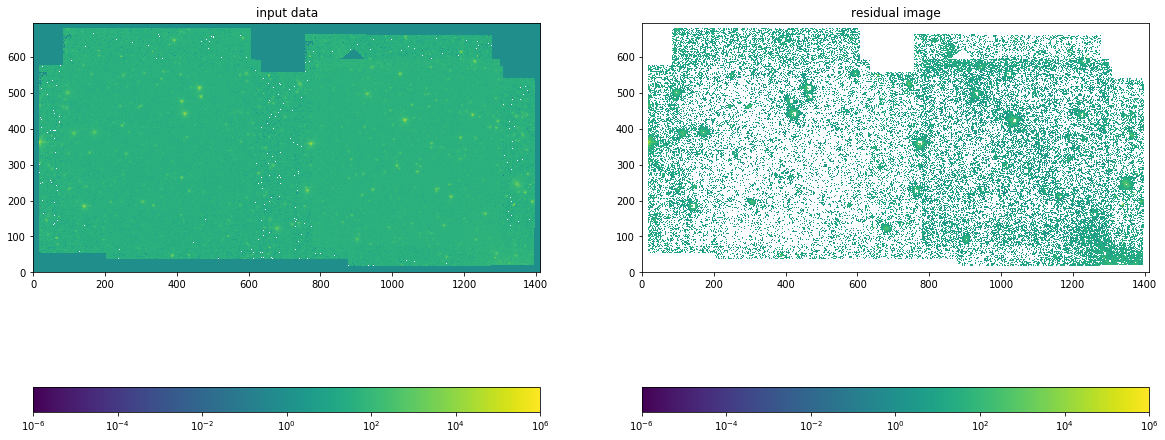

 id   x_fit     y_fit      flux_fit    apparent_mag apparent_mag_err
--- --------- --------- -------------- ------------ ----------------
  1 1182.2692 22.141887      604.34136    18.602175       0.13156688
  2 1335.7201 23.327156      2592.9516    17.023313       0.11382784
  4 1325.4233 24.020858      24818.386    14.570193      0.026461137
  5  1346.686 26.508094      2136.9652    17.233683       0.14094668
  8  1300.237 29.593042      4989.3164    16.310122       0.06123137
 10 1323.7405 32.592222      1479.8395    17.630572       0.19745532
 19  1343.023 45.681609      13786.594    15.207275      0.031294964
 34 1342.0567  58.71917      1658.5035    17.505256       0.16509979
 35 1358.1589 59.610718      1438.1252    17.661125       0.19363987
 47  1370.083  71.96125      12916.023    15.277676      0.031749415
...       ...       ...            ...          ...              ...
 30  84.07602 632.12259  2.9131802e-06    39.438885         49844279
 33 96.873909 636.02064  3.8780236

In [2]:
## DEFINING BASE DATA DIRECTORY ##

base_dir = 'PAL5_data/PAL5__e1/'
channel = '3p6um'

file = base_dir+'PAL5__e1_'+channel+'.fits'
print(file)

corr_file = base_dir+'PAL5__e1_correction_'+channel+'.fits'

## CHANNEL ##

if channel == '3p6um':
    aper_corr = 1.1233         # aperture correction for 337 (6,6,14) apertures in channel 1, given in IRAC handbook §4.10
    ap_err = aper_corr * 0.02  # uncertainty to ~2% as per IRAC handbook
    zmag = 18.80               # zeropoint magnitude given in IRAC handbook §4.8
    zmag_err = 0.02            # uncertainty calculated from F0 = 280.9 +/- 4.1 in IRAC handbook
elif channel == '4p5um':
    aper_corr = 1.1336
    ap_err = aper_corr * 0.02
    zmag = 18.32
    zmag_err = 0.02 

## OPENING FITS FILE AND EXTRACTING DATA ##

with fits.open(file) as header_list:
    header = header_list[0].header
    fluxconv = header['FLUXCONV']
    exptime = header['EXPTIME']
    counts = exptime / fluxconv
    image_data = fits.getdata(file, ext = 0)
    data = image_data * counts
    print('FLUXCONV = {}\nEXPTIME = {}'.format(fluxconv, exptime))
    
## EXTRACTING LOC-DEPENDENT CORRECTIONS ##

with fits.open(corr_file) as hdu_list:
    corr_data = hdu_list[0].data

#___________________________________#
## BUILDING ePSF MODEL FOR PHOTOMETRY
## SOURCE DETECTION FOR ePSF MODEL ##

# PARAMETERS #
sigma_val = 6.
fwhm = 5.
model_threshold = 100.
roundlo = -0.5
roundhi = 0.5
sharphi = 0.7

mean, median, std = sigma_clipped_stats(data, sigma = sigma_val)

starfind_init = DAOStarFinder(fwhm = fwhm, threshold = model_threshold * std, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi)
epsf_sources = starfind_init(data)
print(len(epsf_sources))

# plot detected stars for ePSF model to verify good stars
positions = np.transpose((epsf_sources['xcentroid'], epsf_sources['ycentroid']))
apertures = CircularAperture(positions, r = 6.)

plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
apertures.plot(color = 'black', lw = 1.)
plt.colorbar(fraction = 0.05)
plt.title('Selected ePSF model stars with params: threshold {} * std, fwhm = {}, roundlo = {}, roundhi = {}'
          .format(model_threshold, fwhm, roundlo, roundhi))
plt.grid(b = True, which = 'major', lw = .5, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
plt.gcf().set_size_inches(15, 8)
plt.show()

## APERTURE PHOTOMETRY ##

positions = np.transpose((epsf_sources['xcentroid'], epsf_sources['ycentroid']))
circular_apertures = CircularAperture(positions, r = 6.)
annuli_apertures = CircularAnnulus(positions, r_in = 6., r_out = 14.)
apertures = [circular_apertures, annuli_apertures]

# initial aperture photometry table
phot_init = aperture_photometry(data, apertures)

# background subtraction using sigma-clipped median and annuli
annulus_masks = annuli_apertures.to_mask(method = 'center')

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0] # extract 1D array of data values
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d) # utilise sigma clipping on the annulus masks
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)
# now append bkg_median, aperture background and aperture sum background values to photometry data
phot_init['annulus_median'] = bkg_median
phot_init['aper_bkg'] = bkg_median * circular_apertures.area
phot_init['aper_sum_bkgsub'] = phot_init['aperture_sum_0'] - phot_init['aper_bkg']
print(phot_init)

## STAR CUTOUTS FOR ePSF ##

cutout_size = 200
hsize = (cutout_size - 1) / 2
x = epsf_sources['xcentroid']
y = epsf_sources['ycentroid']
mask = ((x > hsize) & (x < (data.shape[1] - 1 - hsize)) &
       (y > hsize) & (y < (data.shape[0] - 1 - hsize)))

# table of star positions
star_tbl = Table()
star_tbl['x'] = x[mask]
star_tbl['y'] = y[mask]
print(len(star_tbl))

# visualise stars to verify
cutout_pos = np.transpose((star_tbl['x'], star_tbl['y']))
cutout_apers = CircularAperture(cutout_pos, r = 6.)

plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
cutout_apers.plot(color = 'black', lw = 1.)
plt.colorbar(fraction = 0.05)
plt.title('Selected cutout ePSF model stars with params: threshold {} * std, fwhm = {}, roundlo = {}, roundhi = {}'
          .format(model_threshold, fwhm, roundlo, roundhi))
plt.grid(b = True, which = 'major', lw = .5, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
plt.gcf().set_size_inches(15, 8)
plt.show()

## EXTRACT STARS ##

mean_val, median_val, std_val = sigma_clipped_stats(data, sigma = sigma_val)
temp_data = data - median_val

nddata = NDData(data = temp_data)
stars = extract_stars(nddata, star_tbl, size = 25)

# visualise 36 extracted stars
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20), squeeze = True)
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent = 99.)
    ax[i].imshow(stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
plt.show()
plt.close()
    
## BUILD ePSF ##

epsf_builder = EPSFBuilder(oversampling = 2, maxiters = 10, progress_bar = True)
epsf, fitter = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent = 99.)
plt.imshow(epsf.data, cmap = 'viridis', norm = norm, origin = 'lower')
plt.colorbar()
plt.show()

## PSF PHOTOMETRY ##

## SOURCE DETECTION ON ORIGINAL IMAGE ##
# PARAMETERS #

sigma_psf = 5.
fwhm = 5.
roundlo = -0.5
roundhi = 0.5

psf_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma_psf * std, roundlo = roundlo, roundhi = roundhi)
psf_sources = psf_daofind(data)
print('HERE')
print(psf_sources)

psf_positions = np.transpose((psf_sources['xcentroid'], psf_sources['ycentroid']))
psf_apertures = CircularAperture(psf_positions, r = 6.)

plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
psf_apertures.plot(color = 'black', lw = 1.)
plt.colorbar(fraction = 0.05)
plt.title('Detected PSF stars: threshold {} * std, fwhm = {}, roundlo = {}, roundhi = {}'
          .format(sigma_psf, fwhm, roundlo, roundhi))
plt.grid(b = True, which = 'major', lw = .5, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
plt.gcf().set_size_inches(15, 8)
plt.show()

print('Number of stars detected = {}'.format(len(psf_sources)))

## GROUP ##

psf_sources['xcentroid'].name = 'x_0'
psf_sources['ycentroid'].name = 'y_0'

daogroup = DAOGroup(crit_separation = sigma_psf * fwhm)
bkg_estimator = MMMBackground()
fitter = LevMarLSQFitter()

data_psf = np.nan_to_num(data, nan = 1**-7)

## FIXED CENTROIDS ##

epsf.x_0.fixed = True
epsf.y_0.fixed = True
pos = Table(names = ['x_0', 'y_0'], data = [psf_sources['x_0'], psf_sources['y_0']])

## PHOTOMETRY ##

PSF_photometry = IterativelySubtractedPSFPhotometry(finder = psf_daofind,
                                                    group_maker = daogroup,
                                                    bkg_estimator = bkg_estimator,
                                                    psf_model = epsf,
                                                    fitter = fitter,
                                                    niters = 10,
                                                    aperture_radius = 6.,
                                                    fitshape = (11, 11))

result_phot = PSF_photometry(image = data_psf, init_guesses = pos)
residual_image = PSF_photometry.get_residual_image()

#hdu = fits.PrimaryHDU(residual_image)
#hdul = fits.HDUList([hdu])
#hdul.writeto('residual_image_08_fixed_centroids.fits')
print(len(result_phot))

# visualise data
plt.subplot(1, 2, 1)
plt.imshow(data_psf, cmap = 'viridis', norm = LogNorm(), interpolation = 'nearest', origin = 'lower', vmin = 0.000001, vmax = 10**6)
plt.title('input data')
plt.colorbar(orientation = 'horizontal')

plt.subplot(1, 2, 2)
plt.imshow(residual_image, cmap = 'viridis', norm = LogNorm(), interpolation = 'nearest', origin = 'lower', vmin = 0.000001, vmax = 10**6)
plt.title('residual image')
plt.colorbar(orientation = 'horizontal')
plt.gcf().set_size_inches(20, 14)
plt.show()

phot = result_phot                  # redefine photometry table for ease
phot.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\psfphot01_unc_test.txt', format = 'csv', overwrite = True)

## PHOTOMETRY: UNCERTAINTIES ##

# this follows section 2 (pp 8) of Reach et al 2005

#mean_bkg = phot_init['aperture_sum_1'] / annuli_apertures.area
#median_bkg = bkg_median

#bkg_sub_err = median_bkg * circular_apertures.area / pow(annuli_apertures.area, 0.5)
#sky_err = median_bkg * pow(circular_apertures.area, 0.5)
#poisson_err = pow(phot_init['aper_sum_bkgsub'], 0.5)

PSF_err = phot['flux_unc']
PSF_flux = phot['flux_fit'] 

## APPARENT MAGNITUDES ##

phot['apparent_mag'] = float('NaN') # populate a new table (very quirky here, nans?)

for i in range(0, len(phot)):
    # array-location dependent correction
    loc_corr = corr_data[int(phot['y_fit'][i])][int(phot['x_fit'][i])]
    if phot['flux_fit'][i] >= 0:
        phot['apparent_mag'][i] = zmag - 2.5 * math.log10(phot['flux_fit'][i] * aper_corr * loc_corr / counts)
        
## APPARENT MAGNITUDE: UNCERTAINTIES ##

phot['apparent_mag_err'] = float('Nan')
for i in range(0, len(phot)):
    if phot['flux_fit'][i] >= 0:
        #phot['apparent_mag_err'][i] = np.sqrt(zmag_err**2 + (2.5 * np.sqrt((phot['aper_err'][i] / phot['aper_sum_bkgsub'][i])**2 + (ap_err / aper_corr)**2) / np.log(10))**2)
        phot['apparent_mag_err'][i] = pow(zmag_err**2 + (2.5*(pow((PSF_err[i] / PSF_flux[i])**2 + (ap_err / aper_corr)**2, 0.5) / (np.log(10)))**2), 0.5)


# export into csv file
phot['id', 'x_0', 'y_0', 'apparent_mag', 'apparent_mag_err'].write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\psfphot01_test.txt', format = 'csv', overwrite = True)
           
# format columns
for col in phot.colnames:
    phot[col].info.format = '%.8g'
print(phot['id', 'x_fit', 'y_fit', 'flux_fit', 'apparent_mag', 'apparent_mag_err'])